# Multiclass Classification

## Library and Dataset import

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import os
import json
import joblib
from collections import Counter
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
)
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import wilcoxon, shapiro, ttest_rel
import warnings
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.w2v_feature_extraction import W2VTransformer
from utils.text_preprocessing import preprocess_text, TextPreprocessor

## Not_cyberbulling pruning 

In [2]:
# not_cyberbullying pruning 
df_train = pd.read_csv("../dataset/training_set.csv")

df_filtered = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy().reset_index(drop=True)

label2id = {label: idx for idx, label in enumerate(sorted(df_filtered["multiclass_label"].unique()))}
id2label = {v: k for k, v in label2id.items()}

X_text_pruned = df_filtered["text"].fillna("").astype(str)
y_multiclass = df_filtered["multiclass_label"].map(label2id)


print("Final Classes:", label2id)
print("Classe Distribution:")
print(df_filtered["multiclass_label"].value_counts())

model1 = Word2Vec.load("../model/word2vec_model1.model")


Final Classes: {'ethnicity/race': 0, 'gender/sexual': 1, 'religion': 2}
Classe Distribution:
multiclass_label
ethnicity/race    13600
gender/sexual     13600
religion          12792
Name: count, dtype: int64


## NestedLoop CrossValidation

In [3]:
os.makedirs("../model/multiclass", exist_ok=True)
warnings.filterwarnings("ignore", category=UserWarning)

combinations = [
    ("BoW", CountVectorizer(max_features=350)),
    ("TF-IDF", TfidfVectorizer(max_features=350)),
    ("W2V-1", W2VTransformer(model1))
]

param_grid = {
    "LogisticRegression": {
        "model__C": [0.01, 0.1, 1]
    },
    "LinearSVM": {
        "model__C": [0.01, 1, 10]
    },
    "RandomForest": {
        "model__n_estimators": [100, 500, 1000],
        "model__max_depth": [None, 20],
        "model__random_state": [42]
    }
}

classifiers = [
    ("LogisticRegression", LogisticRegression(max_iter=1000), param_grid["LogisticRegression"]),
    ("RandomForest", RandomForestClassifier(), param_grid["RandomForest"]),
    ("LinearSVM", LinearSVC(max_iter=20000), param_grid["LinearSVM"])
]

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_funcs = {
    "accuracy": accuracy_score,
    "precision_macro": lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro"),
    "recall_macro": lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro"),
    "f1_macro": lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro")
}

nested_results = []

for vec_name, vectorizer in combinations:
    for clf_name, clf, grid_params in classifiers:
        print(f"\nNested CV Multiclass — {vec_name} + {clf_name}")
        
        best_params_list = []
        fold_metrics = {m: [] for m in scoring_funcs}
        
        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_text_pruned, y_multiclass), 1):
            X_tr, X_te = X_text_pruned[train_idx], X_text_pruned[test_idx]
            y_tr, y_te = y_multiclass[train_idx], y_multiclass[test_idx]
            
            steps = [("preprocessing", TextPreprocessor()),
                     ("vectorizer",    vectorizer)]
            if "W2V" in vec_name:
                steps.append(("scaler", StandardScaler()))
            steps.append(("model", clf))
            pipe = Pipeline(steps)
            
            grid = GridSearchCV(
                estimator=pipe,
                param_grid=grid_params,
                scoring=list(scoring_funcs.keys()),
                refit="accuracy",
                cv=inner_cv,
                n_jobs=-1,
                verbose=0
            )
            grid.fit(X_tr, y_tr)
            
            best_params_list.append(grid.best_params_)
            
            y_pred = grid.predict(X_te)
            for name, func in scoring_funcs.items():
                fold_metrics[name].append(func(y_te, y_pred))
            
            print(f"  Fold {fold}: best_params={grid.best_params_}")
        
        tuples = [tuple(sorted(d.items())) for d in best_params_list]
        most_common_tuple, _ = Counter(tuples).most_common(1)[0]
        final_params = dict(most_common_tuple)
        print(f"Chosen params (mode over 10 folds): {final_params}")
        
        summary = {
            "Vectorizer": vec_name,
            "Classifier": clf_name,
            **{f"Mean {m}": np.mean(vals) for m, vals in fold_metrics.items()},
            **{f"Std {m}":   np.std(vals)  for m, vals in fold_metrics.items()}
        }
        nested_results.append(summary)
        
        final_steps = [("preprocessing", TextPreprocessor()),
                       ("vectorizer",    vectorizer)]
        if "W2V" in vec_name:
            final_steps.append(("scaler", StandardScaler()))
        final_steps.append(("model", clf))
        final_pipe = Pipeline(final_steps)
        
        final_pipe.set_params(**final_params)
        final_pipe.fit(X_text_pruned, y_multiclass)
        
        out_path = f"../model/multiclass/{clf_name}_{vec_name}_multiclass.pkl"
        joblib.dump(final_pipe, out_path)

nested_df = pd.DataFrame(nested_results) \
              .sort_values(by="Mean accuracy", ascending=False) \
              .reset_index(drop=True)

print("\n=== Nested CV ===")
print(nested_df)
nested_df.to_csv("../model/multiclass/nested_cv_results.csv", index=False)


Nested CV Multiclass — BoW + LogisticRegression
  Fold 1: best_params={'model__C': 1}
  Fold 2: best_params={'model__C': 1}
  Fold 3: best_params={'model__C': 1}
  Fold 4: best_params={'model__C': 1}
  Fold 5: best_params={'model__C': 1}
  Fold 6: best_params={'model__C': 1}
  Fold 7: best_params={'model__C': 1}
  Fold 8: best_params={'model__C': 1}
  Fold 9: best_params={'model__C': 1}
  Fold 10: best_params={'model__C': 1}
Chosen params (mode over 10 folds): {'model__C': 1}

Nested CV Multiclass — BoW + RandomForest
  Fold 1: best_params={'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}
  Fold 2: best_params={'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}
  Fold 3: best_params={'model__max_depth': None, 'model__n_estimators': 1000, 'model__random_state': 42}
  Fold 4: best_params={'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}
  Fold 5: best_params={'model__max_depth': None, 'model__n

## Wilcoxon

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

y = y_multiclass

results = pd.read_csv("../model/multiclass/nested_cv_results.csv")
results_sorted = results.head(9)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
accuracy_scorer = make_scorer(accuracy_score)

scores_dict = {}

for _, row in results_sorted.iterrows():
    vec_name = row["Vectorizer"]
    clf_name = row["Classifier"]

    print(f"Evaluating {clf_name} + {vec_name}")

    model_path = f"../model/multiclass/{clf_name}_{vec_name}_multiclass.pkl"
    pipeline = joblib.load(model_path)

    accuracy_scores = cross_val_score(
        pipeline, X_text_pruned, y, cv=cv, scoring=accuracy_scorer, n_jobs=-1
    )
    key = f"{clf_name} + {vec_name}"
    scores_dict[key] = accuracy_scores

scores_df = pd.DataFrame(scores_dict)
scores_df.to_csv("../model/multiclass/repeated_cv_scores.csv", index=False)

display(scores_df.describe())

model_names = list(scores_df.columns)
N = len(model_names)
matrix = pd.DataFrame(0, index=model_names, columns=model_names)

for i in range(N):
    name_i = model_names[i]
    for j in range(i+1, N):
        name_j = model_names[j]
        diffs = scores_df[name_i] - scores_df[name_j]
        stat_norm, p_norm = shapiro(diffs)
        if p_norm > 0.05:
            stat_test, p_test = ttest_rel(
                scores_df[name_i], scores_df[name_j]
            )
        else:
            stat_test, p_test = wilcoxon(
                scores_df[name_i], scores_df[name_j]
            )
        if p_test < 0.05 and scores_df[name_i].mean() > scores_df[name_j].mean():
            matrix.loc[name_i, name_j] = 1

print("\nPairwise victory matrix (1 = win, 0 = no win):")
display(matrix)

wins = matrix.sum(axis=1)
print("\nNumber of victories per model:")
display(wins)

max_wins = wins.max()
winners = wins[wins == max_wins].index.tolist()
print(f"\nWinner(s) with {max_wins} victories: {', '.join(winners)}")

for winner in winners:
    print(f"\nHead-to-head details for {winner}:")
    for opponent in model_names:
        if opponent == winner:
            continue
        diffs = scores_df[winner] - scores_df[opponent]
        stat_norm, p_norm = shapiro(diffs)
        if p_norm > 0.05:
            stat_test, p_test = ttest_rel(
                scores_df[winner], scores_df[opponent]
            )
            test_name = 't-test'
        else:
            stat_test, p_test = wilcoxon(
                scores_df[winner], scores_df[opponent]
            )
            test_name = 'Wilcoxon'
        result = 'win' if matrix.loc[winner, opponent] == 1 else 'no win'
        print(
            f"{winner} vs {opponent}: {test_name}, "
            f"stat={stat_test:.4f}, p={p_test:.4f} -> {result}"
        )


Evaluating RandomForest + TF-IDF
Evaluating RandomForest + BoW
Evaluating LogisticRegression + BoW
Evaluating LinearSVM + BoW
Evaluating LinearSVM + TF-IDF
Evaluating LogisticRegression + TF-IDF
Evaluating LinearSVM + W2V-1
Evaluating LogisticRegression + W2V-1
Evaluating RandomForest + W2V-1


,RandomForest + TF-IDF,RandomForest + BoW,LogisticRegression + BoW,LinearSVM + BoW,LinearSVM + TF-IDF,LogisticRegression + TF-IDF,LinearSVM + W2V-1,LogisticRegression + W2V-1,RandomForest + W2V-1
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.997725,0.997583,0.997466,0.997483,0.997408,0.996108,0.989956,0.989565,0.966760
std,0.000747,0.000729,0.000838,0.000722,0.000889,0.001288,0.001691,0.002107,0.003277
min,0.995999,0.996250,0.995750,0.995999,0.995500,0.993498,0.984996,0.983746,0.959740
25%,0.997249,0.997062,0.996749,0.997062,0.996812,0.995249,0.989497,0.988624,0.964560
50%,0.997750,0.997499,0.997499,0.997499,0.997500,0.996125,0.990498,0.989747,0.967371
75%,0.998250,0.997999,0.997999,0.997999,0.998000,0.997124,0.991186,0.990998,0.968992
max,0.999250,0.999250,0.999000,0.999250,0.999000,0.998500,0.992248,0.992748,0.971243



Pairwise victory matrix (1 = win, 0 = no win):


,RandomForest + TF-IDF,RandomForest + BoW,LogisticRegression + BoW,LinearSVM + BoW,LinearSVM + TF-IDF,LogisticRegression + TF-IDF,LinearSVM + W2V-1,LogisticRegression + W2V-1,RandomForest + W2V-1
RandomForest + TF-IDF,0,1,0,1,1,1,1,1,1
RandomForest + BoW,0,0,0,0,0,1,1,1,1
LogisticRegression + BoW,0,0,0,0,0,1,1,1,1
LinearSVM + BoW,0,0,0,0,0,1,1,1,1
LinearSVM + TF-IDF,0,0,0,0,0,1,1,1,1
LogisticRegression + TF-IDF,0,0,0,0,0,0,1,1,1
LinearSVM + W2V-1,0,0,0,0,0,0,0,0,1
LogisticRegression + W2V-1,0,0,0,0,0,0,0,0,1
RandomForest + W2V-1,0,0,0,0,0,0,0,0,0



Number of victories per model:


RandomForest + TF-IDF          7
RandomForest + BoW             4
LogisticRegression + BoW       4
LinearSVM + BoW                4
LinearSVM + TF-IDF             4
LogisticRegression + TF-IDF    3
LinearSVM + W2V-1              1
LogisticRegression + W2V-1     1
RandomForest + W2V-1           0
dtype: int64


Winner(s) with 7 victories: RandomForest + TF-IDF

Head-to-head details for RandomForest + TF-IDF:
RandomForest + TF-IDF vs RandomForest + BoW: t-test, stat=2.2067, p=0.0354 -> win
RandomForest + TF-IDF vs LogisticRegression + BoW: t-test, stat=1.8119, p=0.0804 -> no win
RandomForest + TF-IDF vs LinearSVM + BoW: Wilcoxon, stat=78.0000, p=0.0393 -> win
RandomForest + TF-IDF vs LinearSVM + TF-IDF: t-test, stat=2.6167, p=0.0140 -> win
RandomForest + TF-IDF vs LogisticRegression + TF-IDF: t-test, stat=9.2252, p=0.0000 -> win
RandomForest + TF-IDF vs LinearSVM + W2V-1: t-test, stat=27.6067, p=0.0000 -> win
RandomForest + TF-IDF vs LogisticRegression + W2V-1: t-test, stat=23.1626, p=0.0000 -> win
RandomForest + TF-IDF vs RandomForest + W2V-1: t-test, stat=55.1649, p=0.0000 -> win


['ethnicity/race', 'gender/sexual', 'religion']

--- RandomForest + TF-IDF ---
Accuracy:             0.9981
Balanced Accuracy:    0.9981
Macro Precision:      0.9981
Macro Recall:         0.9981
Macro F1 Score:       0.9981


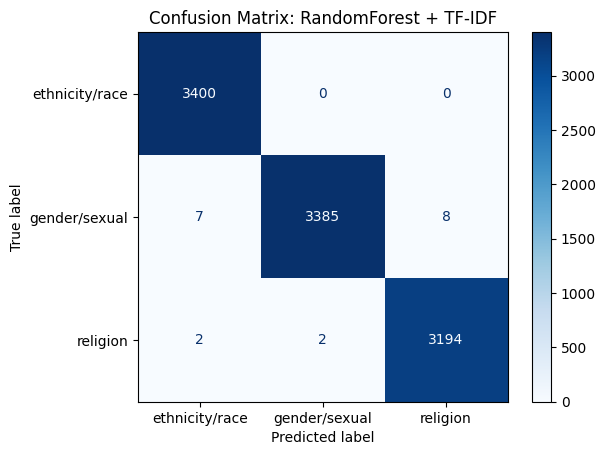

In [5]:
df_eval_sorted = pd.read_csv('../model/multiclass/nested_cv_results.csv')
df_test = pd.read_csv("../dataset/test_set.csv")
df_test = df_test[df_test["multiclass_label"] != "not_cyberbullying"]
X_test_text = df_test["text"]
y_test = df_test["multiclass_label"].map(label2id)

labels = list(label2id.keys())

print(labels)

def print_metrics_and_confmat_multiclass(y_true, y_pred, labels, title):
    print(f"\n--- {title} ---")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"Accuracy:             {acc:.4f}")
    print(f"Balanced Accuracy:    {bal_acc:.4f}")
    print(f"Macro Precision:      {prec:.4f}")
    print(f"Macro Recall:         {rec:.4f}")
    print(f"Macro F1 Score:       {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

top_model = df_eval_sorted.head(1)
predictions = []

model_name = top_model["Classifier"].iloc[0]
vectorizer_name = top_model["Vectorizer"].iloc[0]
    
file_name = f"../model/multiclass/{model_name}_{vectorizer_name}_multiclass.pkl"
clf = joblib.load(file_name)

   
y_pred = clf.predict(X_test_text)

    
predictions.append(y_pred)
    
print_metrics_and_confmat_multiclass(y_test, y_pred, labels, f"{model_name} + {vectorizer_name}")
